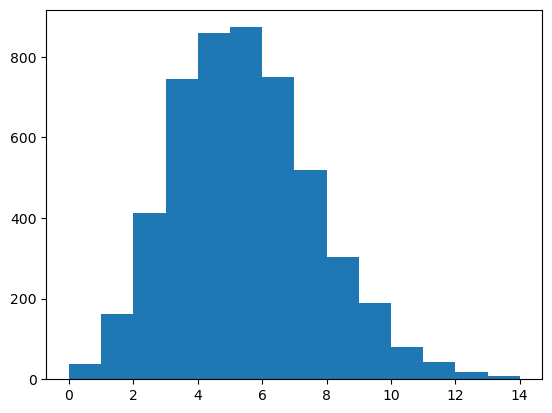

In [ ]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize

class PoissonDemandGenerator:
    def __init__(self, num_samples, periods):
        """
        Initialize the demand generator
        
        Parameters:
        -----------
        num_samples : int
            Number of sample iterations
        periods : int
            Number of periods in each sample
        """
        self.num_samples = num_samples
        self.periods = periods

    def estimate_exponential_tail_rate(self, samples, M, n_tail_buckets=3):
        """
        Estimate exponential tail rate using the last few buckets before censoring
        
        Parameters:
        -----------
        samples : array
            Observed samples
        M : int
            Censoring threshold
        n_tail_buckets : int, optional
            Number of buckets to use for rate estimation
        
        Returns:
        --------
        float: Estimated exponential tail rate
        """
        # Flatten samples if multidimensional
        flat_samples = samples.flatten()
        
        # Filter samples in the tail region before censoring
        tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples < M)]
        
        # Fit exponential distribution to these samples
        def neg_log_likelihood(rate):
            return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
        
        # Optimize to find the rate that minimizes negative log-likelihood
        result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
        
        return result.x

    def generate_censored_demand(self, problem_params, demand_params, seed=None):
        """
        Generate Poisson demand with censoring and exponential tail imputation
        
        Parameters:
        -----------
        problem_params : dict
            Parameters defining the problem, including censoring threshold
        demand_params : dict
            Parameters for demand generation (e.g., mean)
        seed : int, optional
            Random seed for reproducibility
        
        Returns:
        --------
        numpy.ndarray: Censored and imputed demand samples
        """
        # Set seed
        if seed is not None:
            np.random.seed(seed)
        
        # Extract censoring threshold
        M = problem_params.get('censoring_threshold', 7)
        
        # Generate original Poisson samples
        orig_samples = np.random.poisson(
            demand_params['mean'], 
            size=(self.num_samples, problem_params['n_stores'], self.periods)
        )
        
        # Create a copy for tail imputation
        imputed_samples = np.minimum(orig_samples, M)
        
        # Identify which samples were censored
        censored_mask = orig_samples >= M
        
        # Estimate exponential tail rate (across all samples)
        lambda_exp = self.estimate_exponential_tail_rate(orig_samples, M)
        
        # Generate exponential samples for censored values
        censored_tails = np.round(
            M + np.random.exponential(1/lambda_exp, size=np.sum(censored_mask))
        ).astype(int)
        
        # Replace censored values with imputed tail samples
        imputed_samples[censored_mask] = censored_tails
        
        return imputed_samples

# # Example usage
# num_samples = 100
# periods = 10
# demand_generator = PoissonDemandGenerator(num_samples, periods)

# problem_params = {
#     'n_stores': 5,
#     'censoring_threshold': 20
# }

# demand_params = {
#     'mean': 5
# }

# censored_demand = demand_generator.generate_censored_demand(problem_params, demand_params)

# # make a histogram of the flattened samples
# import matplotlib.pyplot as plt
# plt.hist(censored_demand.flatten(), bins=range(15))
# plt.show()

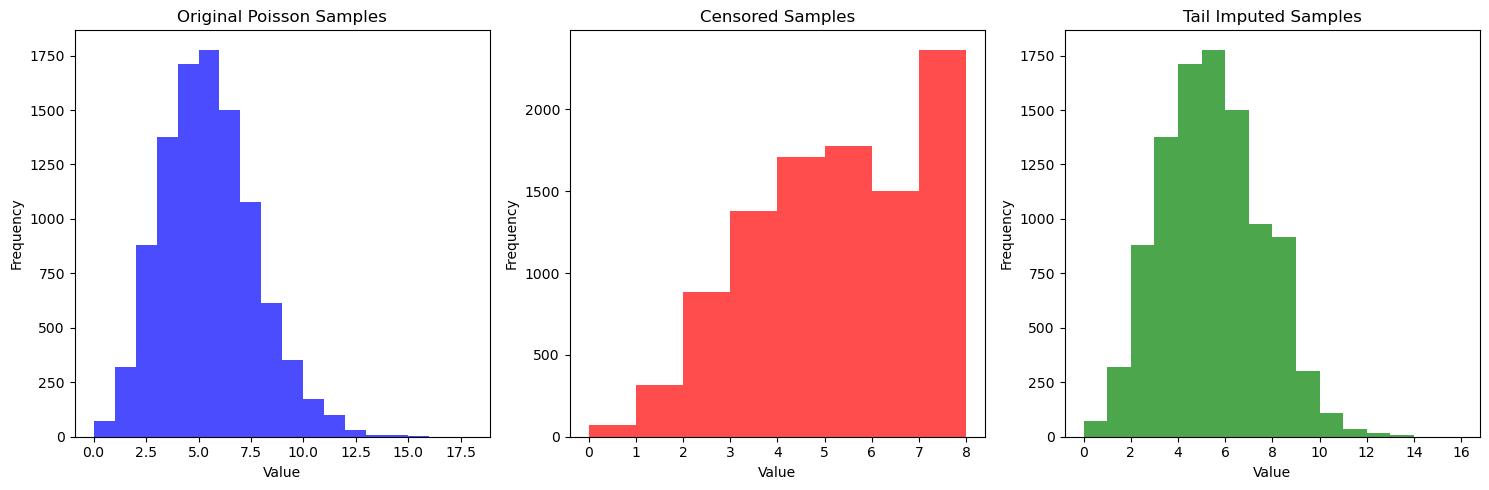


Value Counts:
Value 0: 0.74%
Value 1: 3.18%
Value 2: 8.81%
Value 3: 13.77%
Value 4: 17.09%
Value 5: 17.77%
Value 6: 15.00%
Value 7: 9.76%
Value 8: 9.17%
Value 9: 3.00%
Value 10: 1.09%
Value 11: 0.35%
Value 12: 0.18%
Value 13: 0.08%
Value 15: 0.01%

Estimated Tail Rate: 1.0438


In [47]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def estimate_exponential_tail_rate(samples, M, n_tail_buckets=3):
    """
    Estimate exponential tail rate using the last few buckets before censoring
    """
    # Filter samples in the tail region before censoring
    tail_samples = samples[(samples >= M-n_tail_buckets) & (samples < M)]
    
    # Fit exponential distribution to these samples
    def neg_log_likelihood(rate):
        return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
    
    # Optimize to find the rate that minimizes negative log-likelihood
    result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
    
    return result.x

def generate_and_impute(lambda_poisson, M, n_samples=10000, seed=42, n_tail_buckets=3):
    """
    Generate Poisson samples, censor at M, and impute exponential tail
    with rate estimated from observed data
    """
    np.random.seed(seed)
    
    # Generate Poisson samples
    orig_samples = np.random.poisson(lambda_poisson, n_samples)
    
    # Censor samples at M
    censored_samples = np.minimum(orig_samples, M)
    
    # Identify which samples were censored
    censored_mask = orig_samples >= M
    
    # Estimate exponential tail rate from observed data
    lambda_exp = estimate_exponential_tail_rate(orig_samples, M, n_tail_buckets)
    
    # Generate tail samples
    tail_samples = censored_samples.astype(int)
    
    # Impute censored samples using exponential distribution
    # Start imputation from M and add exponential samples
    censored_indices = np.where(censored_mask)[0]
    tail_samples[censored_indices] = np.round(
        M + np.random.exponential(1/lambda_exp, sum(censored_mask))
    ).astype(int)
    
    return {
        'original_samples': orig_samples,
        'censored_samples': censored_samples,
        'tail_imputed_samples': tail_samples,
        'estimated_tail_rate': lambda_exp,
        'censoring_rate': np.mean(censored_mask)
    }

def visualize_results(results):
    """
    Visualize the distribution of original, censored, and imputed samples
    """
    plt.figure(figsize=(15, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    plt.hist(results['original_samples'], bins=range(int(max(results['original_samples']))+2), alpha=0.7, color='blue')
    plt.title('Original Poisson Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Censored distribution
    plt.subplot(1, 3, 2)
    plt.hist(results['censored_samples'], bins=range(int(max(results['censored_samples']))+2), alpha=0.7, color='red')
    plt.title('Censored Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Tail Imputed distribution
    plt.subplot(1, 3, 3)
    plt.hist(results['tail_imputed_samples'], bins=range(int(max(results['tail_imputed_samples']))+2), alpha=0.7, color='green')
    plt.title('Tail Imputed Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Print out value counts to check probabilities
    print("\nValue Counts:")
    unique, counts = np.unique(results['tail_imputed_samples'], return_counts=True)
    for val, count in zip(unique, counts):
        print(f"Value {val}: {count/len(results['tail_imputed_samples'])*100:.2f}%")
    
    print(f"\nEstimated Tail Rate: {results['estimated_tail_rate']:.4f}")

# Example usage
lambda_poisson = 5  # Poisson rate
M = 7  # Censoring threshold

# decorate to allow zooming in
results = generate_and_impute(lambda_poisson, M)
visualize_results(results)

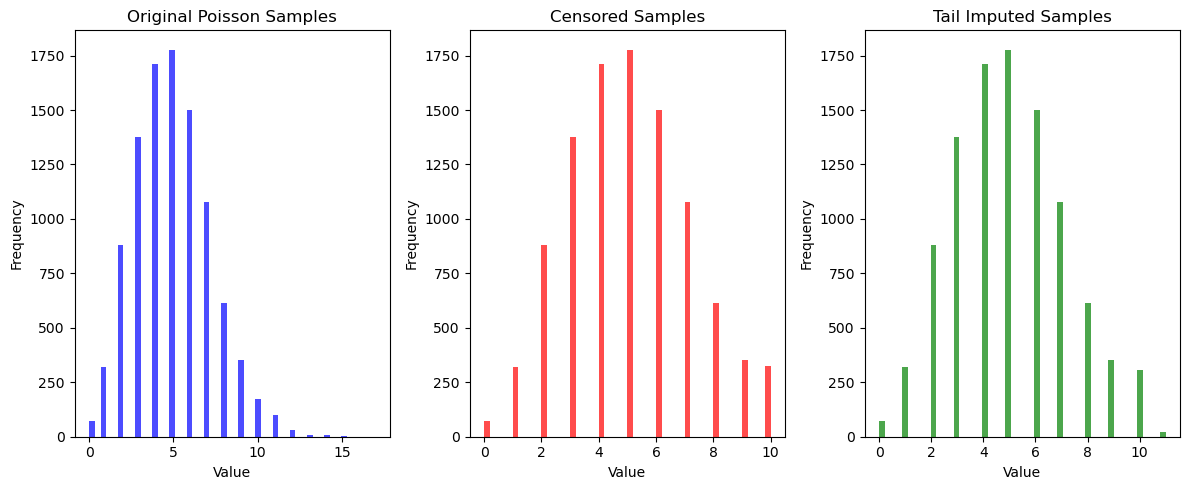

Censoring rate: 3.25%
Original mean: 5.00
Censored mean: 4.98
Imputed mean: 4.98


In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def generate_and_impute(lambda_poisson, M, n_samples=10000, seed=42):
    """
    Generate Poisson samples, censor at M, and impute exponential tail
    
    Parameters:
    -----------
    lambda_poisson : float
        Rate parameter for Poisson distribution
    M : int
        Censoring threshold
    n_samples : int, optional
        Number of samples to generate
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    dict containing original samples, censored samples, and imputed samples
    """
    # Set random seed
    np.random.seed(seed)
    
    # Generate Poisson samples
    orig_samples = np.random.poisson(lambda_poisson, n_samples)
    
    # Censor samples at M
    censored_samples = np.minimum(orig_samples, M)
    
    # Identify which samples were censored
    censored_mask = orig_samples >= M
    
    # Estimate exponential rate for tail
    # For censored samples, we know the true rate should equal the Poisson rate
    # This is a key insight when the underlying distribution is known
    lambda_exp = lambda_poisson
    
    # Generate tail samples for censored observations
    tail_samples = np.zeros(n_samples)
    tail_samples[~censored_mask] = censored_samples[~censored_mask]
    tail_samples[censored_mask] = M + np.random.exponential(1/lambda_exp, sum(censored_mask))
    # make samples integers
    tail_samples = np.round(tail_samples).astype(int)
    
    return {
        'original_samples': orig_samples,
        'censored_samples': censored_samples,
        'tail_imputed_samples': tail_samples,
        'censoring_rate': np.mean(censored_mask)
    }

def visualize_results(results):
    """
    Visualize the distribution of original, censored, and imputed samples
    """
    plt.figure(figsize=(12, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    plt.hist(results['original_samples'], bins=50, alpha=0.7, color='blue')
    plt.title('Original Poisson Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Censored distribution
    plt.subplot(1, 3, 2)
    plt.hist(results['censored_samples'], bins=50, alpha=0.7, color='red')
    plt.title('Censored Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Tail Imputed distribution
    plt.subplot(1, 3, 3)
    plt.hist(results['tail_imputed_samples'], bins=50, alpha=0.7, color='green')
    plt.title('Tail Imputed Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Example usage
lambda_poisson = 5  # Poisson rate
M = 10  # Censoring threshold

results = generate_and_impute(lambda_poisson, M)
visualize_results(results)

# Print some statistics
print(f"Censoring rate: {results['censoring_rate']*100:.2f}%")
print(f"Original mean: {np.mean(results['original_samples']):.2f}")
print(f"Censored mean: {np.mean(results['censored_samples']):.2f}")
print(f"Imputed mean: {np.mean(results['tail_imputed_samples']):.2f}")

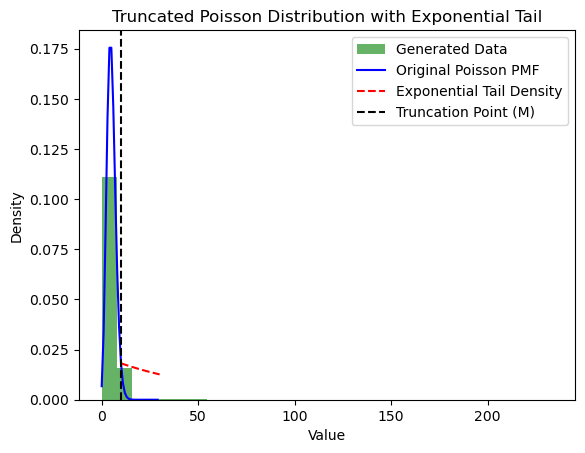

Estimated rate of exponential tail: 0.0181


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon

def generate_truncated_poisson_with_tail(lambda_poisson, M, size):
    """
    Generates data from a Poisson distribution truncated at M, 
    with an exponential tail starting at M.

    Parameters:
        lambda_poisson (float): Rate parameter for the Poisson distribution.
        M (int): Truncation value.
        size (int): Total number of samples to generate.

    Returns:
        np.array: Array of generated samples.
        float: Rate of the exponential tail.
    """
    # Generate Poisson samples
    poisson_samples = np.random.poisson(lambda_poisson, size)
    
    # Truncate Poisson samples at M
    truncated_samples = poisson_samples[poisson_samples <= M]
    
    # Calculate remaining samples needed
    n_remaining = size - len(truncated_samples)
    
    # Calculate the probability mass beyond M
    prob_mass_beyond_M = 1 - poisson.cdf(M, lambda_poisson)
    
    # Define the rate of the exponential tail
    lambda_exp = prob_mass_beyond_M / (1 / lambda_poisson)
    
    # Ensure the exponential tail density does not exceed the Poisson density at M
    poisson_density_at_M = poisson.pmf(M, lambda_poisson)
    max_exp_density = lambda_exp
    if max_exp_density > poisson_density_at_M:
        lambda_exp = poisson_density_at_M
    
    # Generate values for the exponential tail
    if n_remaining > 0:
        exp_tail = M + np.random.exponential(1 / lambda_exp, n_remaining)
    else:
        exp_tail = np.array([])

    # Combine and return
    return np.concatenate([truncated_samples, exp_tail]), lambda_exp

# Parameters
lambda_poisson = 5  # Rate of the Poisson distribution
M = 10              # Truncation value
size = 10000        # Number of samples

# Generate data
data, lambda_exp = generate_truncated_poisson_with_tail(lambda_poisson, M, size)

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Generated Data')

# Plot original Poisson density
x = np.arange(0, M + 20)
poisson_pmf = poisson.pmf(x, lambda_poisson)
plt.plot(x, poisson_pmf, 'b-', label='Original Poisson PMF')

# Plot exponential tail density
x_tail = np.linspace(M, M + 20, 1000)
exp_density = lambda_exp * np.exp(-lambda_exp * (x_tail - M))
plt.plot(x_tail, exp_density, 'r--', label='Exponential Tail Density')

plt.axvline(M, color='black', linestyle='--', label='Truncation Point (M)')
plt.title("Truncated Poisson Distribution with Exponential Tail")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Print the estimated rate of the exponential tail
print(f"Estimated rate of exponential tail: {lambda_exp:.4f}")


/tmp/ipykernel_90239/1816252729.py:84: RuntimeWarning: invalid value encountered in true_divide
  poisson_pmf_truncated /= np.sum(poisson_pmf_truncated)


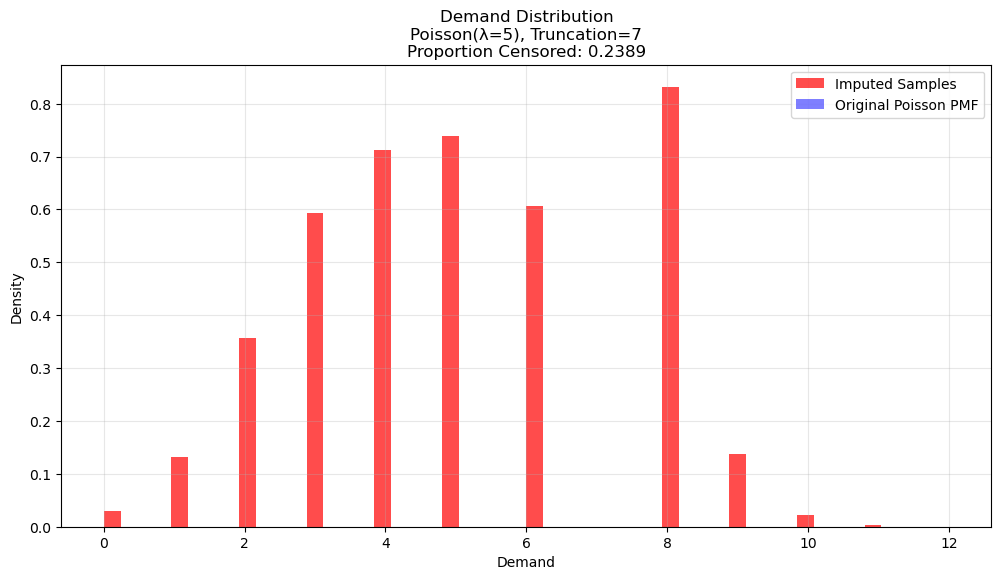

Proportion of samples censored: 0.2389
Mean of original Poisson: 5
Mean of imputed samples: 5.0322


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def sample_censored_demand(n_samples, lambda_demand, truncation_value):
    """
    Sample from a censored demand distribution with normalized tail.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    lambda_demand : float
        Mean of the Poisson distribution for original demand
    truncation_value : float
        Value at which demand is censored
    
    Returns:
    --------
    numpy.ndarray
        Sampled demand values
    float
        Proportion of samples above truncation value
    """
    # Generate initial Poisson samples
    poisson_samples = np.random.poisson(lambda_demand, n_samples)
    
    # Calculate the proportion of samples above truncation value
    prop_censored = np.mean(poisson_samples >= truncation_value)
    
    # Create mask for censored (truncated) samples
    censored_mask = poisson_samples >= truncation_value
    
    # Preserve the original discrete Poisson distribution up to truncation_value
    censored_samples = poisson_samples.copy()
    
    # For censored samples, use geometric tail distribution
    # This ensures remaining probability mass is distributed proportionally
    n_censored = np.sum(censored_mask)
    
    # Geometric tail parameters
    tail_base = 1.2  # Can be adjusted to control tail behavior
    tail_samples = (
        truncation_value + 
        np.floor(np.random.geometric(1/tail_base, n_censored))
    )
    
    # Replace censored samples
    censored_samples[censored_mask] = tail_samples
    
    return censored_samples, prop_censored

def plot_demand_distributions(lambda_demand, truncation_value, n_samples=10000):
    """
    Plot original and imputed demand distributions.
    
    Parameters:
    -----------
    lambda_demand : float
        Mean of the Poisson distribution
    truncation_value : float
        Value at which demand is censored
    n_samples : int, optional
        Number of samples to generate
    """
    # Sample demands and get censored proportion
    samples, prop_censored = sample_censored_demand(
        n_samples, 
        lambda_demand, 
        truncation_value
    )
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Original Poisson distribution
    x_poisson = np.arange(0, max(samples) + 5)
    poisson_pmf = stats.poisson.pmf(x_poisson, lambda_demand)
    
    # Modify PMF to match truncation
    poisson_pmf_truncated = poisson_pmf.copy()
    norm_factor = 1 - np.sum(poisson_pmf[poisson_pmf.shape[0] >= truncation_value])
    poisson_pmf_truncated[poisson_pmf_truncated.shape[0] >= truncation_value] = 0
    poisson_pmf_truncated /= np.sum(poisson_pmf_truncated)
    
    # Plot original PMF
    plt.bar(x_poisson[:truncation_value], 
            poisson_pmf_truncated[:truncation_value], 
            alpha=0.5, label='Original Poisson PMF', color='blue')
    
    # Histogram of imputed samples
    plt.hist(samples, bins=50, density=True, alpha=0.7, 
             label='Imputed Samples', color='red')
    
    plt.title(f'Demand Distribution\nPoisson(λ={lambda_demand}), Truncation={truncation_value}\nProportion Censored: {prop_censored:.4f}')
    plt.xlabel('Demand')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return samples, prop_censored

# Example usage
lambda_demand = 5  # Poisson mean
truncation_value = 7  # Censoring threshold

# Demonstrate sampling and plotting
samples, prop_censored = plot_demand_distributions(lambda_demand, truncation_value)

# Additional analysis
print(f"Proportion of samples censored: {prop_censored:.4f}")
print(f"Mean of original Poisson: {lambda_demand}")
print(f"Mean of imputed samples: {np.mean(samples)}")

/tmp/ipykernel_27782/2575369338.py:70: RuntimeWarning: invalid value encountered in true_divide
  poisson_pmf_truncated /= np.sum(poisson_pmf_truncated)


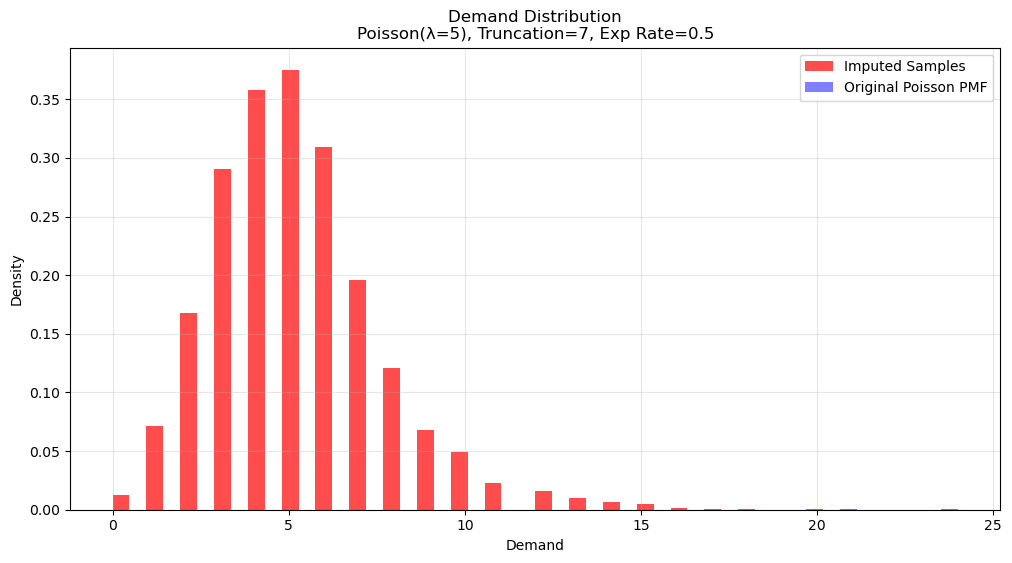

Mean of original Poisson: 5
Mean of imputed samples: 5.1371
Proportion of samples above truncation: 0.2397


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def sample_censored_demand(n_samples, lambda_demand, truncation_value, exponential_rate):
    """
    Sample from a censored demand distribution with exponential tail.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    lambda_demand : float
        Mean of the Poisson distribution for original demand
    truncation_value : float
        Value at which demand is censored
    exponential_rate : float
        Rate parameter for the exponential tail distribution
    
    Returns:
    --------
    numpy.ndarray
        Sampled demand values
    """
    # Generate initial Poisson samples
    poisson_samples = np.random.poisson(lambda_demand, n_samples)
    
    # Create mask for censored (truncated) samples
    censored_mask = poisson_samples >= truncation_value
    
    # Create output samples
    censored_samples = poisson_samples.copy()
    
    # For censored samples, add exponential tail to truncation value
    censored_samples[censored_mask] = (
        truncation_value + 
        np.random.exponential(1/exponential_rate, np.sum(censored_mask))
    )
    
    return censored_samples

def plot_demand_distributions(lambda_demand, truncation_value, exponential_rate, n_samples=10000):
    """
    Plot original and imputed demand distributions.
    
    Parameters:
    -----------
    lambda_demand : float
        Mean of the Poisson distribution
    truncation_value : float
        Value at which demand is censored
    exponential_rate : float
        Rate parameter for exponential tail distribution
    n_samples : int, optional
        Number of samples to generate
    """
    # Sample demands
    samples = sample_censored_demand(n_samples, lambda_demand, truncation_value, exponential_rate)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Original Poisson distribution
    x_poisson = np.arange(0, truncation_value + 10)
    poisson_pmf = stats.poisson.pmf(x_poisson, lambda_demand)
    
    # Modify PMF to match truncation
    poisson_pmf_truncated = poisson_pmf.copy()
    poisson_pmf_truncated[poisson_pmf_truncated.shape[0] >= truncation_value] = 0
    poisson_pmf_truncated /= np.sum(poisson_pmf_truncated)
    
    # Plot original PMF
    plt.bar(x_poisson[:truncation_value], 
            poisson_pmf_truncated[:truncation_value], 
            alpha=0.5, label='Original Poisson PMF', color='blue')
    
    # Histogram of imputed samples
    plt.hist(samples, bins=50, density=True, alpha=0.7, 
             label='Imputed Samples', color='red')
    
    plt.title(f'Demand Distribution\nPoisson(λ={lambda_demand}), Truncation={truncation_value}, Exp Rate={exponential_rate}')
    plt.xlabel('Demand')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return samples

# Example usage
lambda_demand = 5  # Poisson mean
truncation_value = 7  # Censoring threshold
exponential_rate = 0.5  # Rate for exponential tail

# Demonstrate sampling and plotting
samples = plot_demand_distributions(lambda_demand, truncation_value, exponential_rate)

# Additional analysis
print(f"Mean of original Poisson: {lambda_demand}")
print(f"Mean of imputed samples: {np.mean(samples)}")
print(f"Proportion of samples above truncation: {np.mean(samples >= truncation_value):.4f}")